# Using a New Machine Learning Classifier

In this activity, you’ll evaluate how our earlier trading strategy behaves when it uses a different machine learning classification model.

## Instructions:

1. Run all the cells up to the “Add a New Machine Learning Model” section.

2. Import the `LogisticRegression` model from scikit-learn.

    > **Rewind** Recall that `LogisticRegression` models are used for binary classification problems.

3. Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

4. Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

5. Backtest the `LogisticRegression` model to evaluate its performance.

6. Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data.  Did the logistic regression model perform better than SVM?


## References:

[SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

[SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [1]:
# Imports
import pandas as pd
from pathlib import Path

### Read the CSV file into Pandas DataFrame

In [19]:
trading_df = pd.read_csv(
    # Path("./Resources/emerging_markets_ohlcv.csv"), 
    Path("Resources/emerging_markets_ohlcv.csv"),
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

#trading_df = trading_df.resample('B').mean() 
# Review the DataFrame
trading_df.head()
trading_df.tail()
trading_df.shape

(4323, 5)

In [3]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("Resources/ohlcv.csv"), 
    index_col="date", 
    infer_datetime_format=True, 
    parse_dates=True
)




# Review the DataFrame
trading_df.head()

,open,high,low,close,volume
date,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874


### Add a daily return values column to the DataFrame

In [20]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())


,open,high,low,close,volume,actual_returns
date,,,,,,
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100,0.006295
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100,0.018349
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200,0.000819
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200,0.000818
2015-01-26 12:30:00,24.34,24.34,24.33,24.33,200,-0.005315


,open,high,low,close,volume,actual_returns
date,,,,,,
2021-01-22 09:30:00,33.27,33.27,33.27,33.27,100,-0.006866
2021-01-22 11:30:00,33.35,33.35,33.35,33.35,200,0.002405
2021-01-22 13:45:00,33.42,33.42,33.42,33.42,200,0.002099
2021-01-22 14:30:00,33.47,33.47,33.47,33.47,200,0.001496
2021-01-22 15:45:00,33.47,33.47,33.44,33.44,783,-0.000896


---

### Generating the Features and Target Sets

In [21]:
# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df['sma_fast'] = trading_df['close'].rolling(window=short_window).mean()

In [22]:
# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df['sma_slow'] = trading_df['close'].rolling(window=long_window).mean()

In [23]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [24]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[['sma_fast', 'sma_slow']].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
date,,
2015-04-02 14:45:00,24.9175,24.3214
2015-04-02 15:00:00,24.9200,24.3308
2015-04-02 15:15:00,24.9250,24.3360
2015-04-02 15:30:00,24.9325,24.3411
2015-04-02 15:45:00,24.9475,24.3463


,sma_fast,sma_slow
date,,
2021-01-22 09:30:00,33.2025,30.40215
2021-01-22 11:30:00,33.2725,30.44445
2021-01-22 13:45:00,33.3850,30.48745
2021-01-22 14:30:00,33.3775,30.53085
2021-01-22 15:45:00,33.4200,30.57495


#### Create the target set

In [25]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df['signal'] = 0.0

In [26]:
# Create the signal to buy
trading_df.loc[(trading_df['actual_returns'] >= 0), 'signal'] = 1

In [27]:
# Create the signal to sell
trading_df.loc[(trading_df['actual_returns'] < 0), 'signal'] = -1

In [28]:
# Copy the new signal column to a new Series called y.
y = trading_df['signal'].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [29]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [30]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 14:45:00


In [37]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=48)

# Display the training end date
print(training_end)

2019-04-02 14:45:00


In [38]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.shape

(3297, 2)

#### Creating the Testing Datasets

In [39]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
date,,
2019-04-03 10:30:00,25.6275,25.21805
2019-04-03 10:45:00,25.7650,25.23205
2019-04-03 11:00:00,25.9075,25.24205
2019-04-03 11:15:00,26.0375,25.25065
2019-04-03 11:45:00,26.0425,25.25985


#### Standardizing the Data

In [40]:
# Imports
from sklearn.preprocessing import StandardScaler

In [41]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [44]:
from sklearn.model_selection import GridSearchCV
# Imports
from sklearn import svm

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ .0001, .001, .01, 1, 10],              # The regularization parameter
                # 'gamma': [1,0.1,0.01,0.001,0.0001],                           # The kernel coefficient
                'kernel': ['rbf', 'linear', 'poly'],                          # The kernel type used
                #'degree':[2,3,4,5],                                          # Degree of polynomial function
                #'shrinking':[True, False],                                   # To use shrinking heuristic
                #'probability':[False, True]                                  # Enable probability estimates
             }                                 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=15)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_scaled, y_train)

Fitting 15 folds for each of 15 candidates, totalling 225 fits


In [45]:
print(grid_search.best_params_)

{'C': 0.0001, 'kernel': 'rbf'}


In [19]:

from sklearn.metrics import classification_report

In [50]:
# Create the classifier model
svm_model = svm.SVC(C=10, gamma=1, kernel='rbf')
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [51]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions, zero_division=True)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.55      0.03      0.06      1451
         1.0       0.56      0.98      0.72      1846

    accuracy                           0.56      3297
   macro avg       0.56      0.51      0.39      3297
weighted avg       0.56      0.56      0.43      3297



---

### Backtesting a Machine Learning Trading Algorithm

In [22]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [24]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions, zero_division=True)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      0.00      0.00      1806
         1.0       0.56      1.00      0.72      2288

    accuracy                           0.56      4094
   macro avg       0.78      0.50      0.36      4094
weighted avg       0.75      0.56      0.40      4094



In [25]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2015-07-02 15:15:00,1.0,-0.000828,-0.000828
2015-07-02 15:45:00,1.0,-0.000829,-0.000829
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721


<AxesSubplot:xlabel='date'>

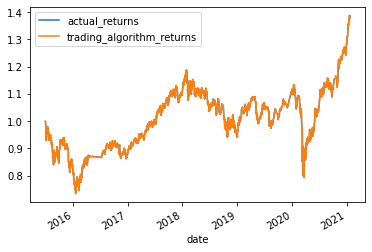

In [26]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Step 2: Import the `LogisticRegression` model from scikit-learn.


In [27]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [28]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

## Step 3: Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [29]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Step 4: Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [30]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Diplay the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [31]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.67      0.08      0.15        49
         1.0       0.63      0.97      0.77        80

    accuracy                           0.64       129
   macro avg       0.65      0.53      0.46       129
weighted avg       0.65      0.64      0.53       129



## Step 5: Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [32]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [33]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.37      1806
         1.0       0.56      0.67      0.61      2288

    accuracy                           0.52      4094
   macro avg       0.50      0.50      0.49      4094
weighted avg       0.50      0.52      0.50      4094



## Step 6: Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [34]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.37      1806
         1.0       0.56      0.67      0.61      2288

    accuracy                           0.52      4094
   macro avg       0.50      0.50      0.49      4094
weighted avg       0.50      0.52      0.50      4094



In [35]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       1.00      0.00      0.00      1806
         1.0       0.56      1.00      0.72      2288

    accuracy                           0.56      4094
   macro avg       0.78      0.50      0.36      4094
weighted avg       0.75      0.56      0.40      4094



In [132]:
### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** Yes! The logistic regression model performs a bit better than the SVM model since it has a higher accuracy score.